This dataset shows the NYC taxi demand from 2014–07–01 to 2015–01–31 with an observation every half hour. In this period 5 anomalies are present, in term of deviation from a normal behavior. They occur respectively during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm.
goal is to detect the anomalies in the best way possible.

In [1]:
import keras
from keras import optimizers
from keras import losses
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM, Bidirectional,  SpatialDropout1D, Conv1D
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import math
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)


C:\Users\Shumpu\Anaconda2\envs\p36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\Shumpu\Anaconda2\envs\p36\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Shumpu\Anaconda2\envs\p36\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Shumpu\Anaconda2\envs\p36\lib\si

Python:  3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
pandas:  0.24.2
numpy:  1.17.3
seaborn:  0.8.1
matplotlib:  2.2.2
sklearn:  0.19.1
Keras:  2.0.8
Tensorflow:  1.10.0


In [2]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            x = group.index.values
            y = group.error
            axes.plot(x, y, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
        plt.figure(figsize=(10, 8))
        plt.plot(error, marker='o', ms=3.5, linestyle='',
                 label='Point')

        plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="r", zorder=100, label='Threshold')
        plt.legend()
        plt.title("Reconstruction error")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

In [3]:

tensorlogs = ["art_daily_no_noise", #0
              "art_daily_nojump", #1
              "art_daily_jumpsdown",#2 
              "art_daily_perfect_square_wave", #3 
              "art_increase_spike_density",  #4
              "art_load_balancer_spikes",  #5
              "ambient_temperature_system_failure", #6 
              "nyc_taxi",  #7
              "ec2_cpu_utilization", #8
              "rds_cpu_utilization"] #9 

dataFilePaths = ['data/art_daily_no_noise.csv',
                 'data/art_daily_nojump.csv',
                 'data/art_daily_jumpsdown.csv',
                 'data/art_daily_perfect_square_wave.csv',
                 'data/art_increase_spike_density.csv',
                 'data/art_load_balancer_spikes.csv',
                 'data/ambient_temperature_system_failure.csv',
                 'datasets/nytaxi/nyc_taxi.csv',
                 'data/ec2_cpu_utilization.csv',
                 'data/rds_cpu_utilization.csv']




In [4]:
i = 7

tensorlog = tensorlogs[i]
dataFilePath = dataFilePaths[i]
print("tensorlog: ", tensorlog)
print("dataFilePath: ", dataFilePath)

tensorlog:  nyc_taxi
dataFilePath:  datasets/nytaxi/nyc_taxi.csv


In [5]:
df = pd.read_csv(filepath_or_buffer=dataFilePath, header=0, sep=',')
print('Shape:' , df.shape[0])
print('Head:')
df['Datetime'] = pd.to_datetime(df['timestamp'])
df['dayofweek'] = df['Datetime'].dt.dayofweek
df['month'] = df['Datetime'].dt.month
df['hour'] = df['Datetime'].dt.hour
#df['hour'] = [1 if (ele >= 8 and ele < 20) else 0 for ele in df["hour"]]


df = df[(df.Datetime > '2014-07-18') & (df.Datetime < '2015-11-30')]
df = df.reset_index(drop=True)
print(df.shape)
print(df.head(5))
training_points = 5000

Shape: 10320
Head:
(9503, 6)
             timestamp  value            Datetime  dayofweek  month  hour
0  2014-07-18 00:30:00  16734 2014-07-18 00:30:00          4      7     0
1  2014-07-18 01:00:00  14106 2014-07-18 01:00:00          4      7     1
2  2014-07-18 01:30:00  11587 2014-07-18 01:30:00          4      7     1
3  2014-07-18 02:00:00   8951 2014-07-18 02:00:00          4      7     2
4  2014-07-18 02:30:00   7199 2014-07-18 02:30:00          4      7     2


Text(0.5,1,'Time Series of value by date time')

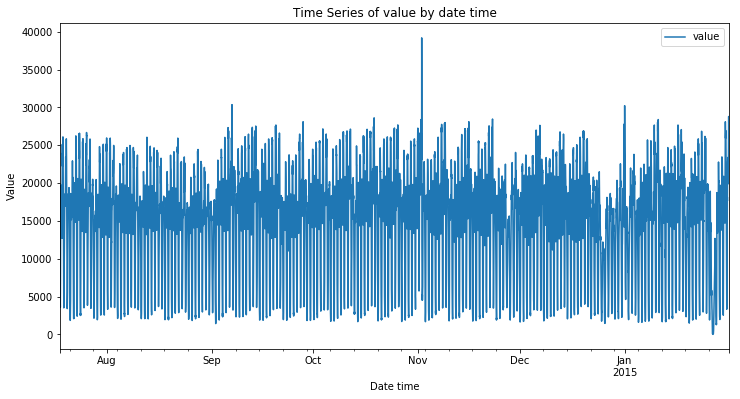

In [6]:
df.shape
df.plot(x='Datetime', y='value', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

Text(0,0.5,'correlation coeff')

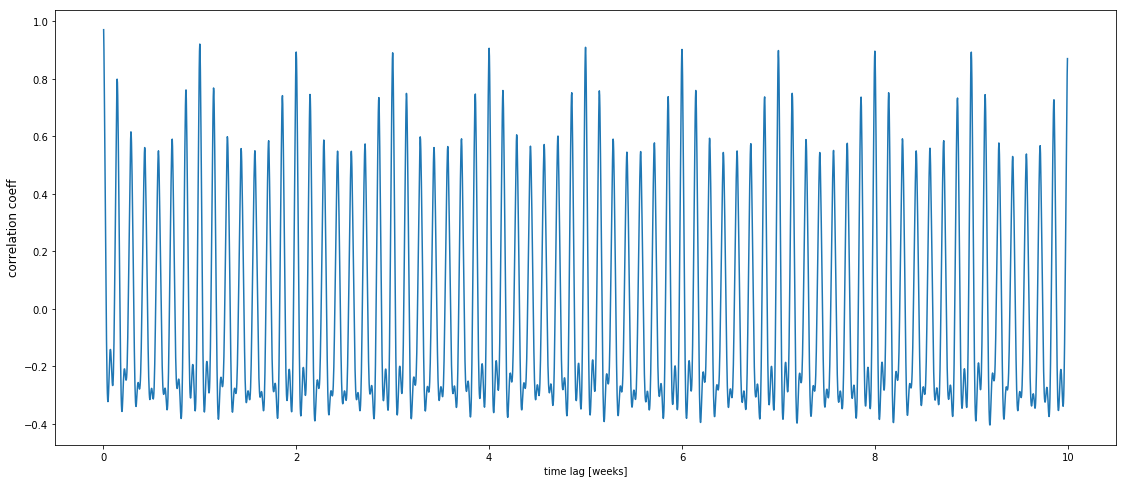

In [7]:
timeLags = np.arange(1,10*48*7)
autoCorr = [df.value.autocorr(lag=dt) for dt in timeLags]
plt.figure(figsize=(19,8))
plt.plot(1.0/(48*7)*timeLags, autoCorr)
plt.xlabel('time lag [weeks]')
plt.ylabel('correlation coeff', fontsize=12)

(9503, 6)


Text(0.5,1,'Time Series of value by date time')

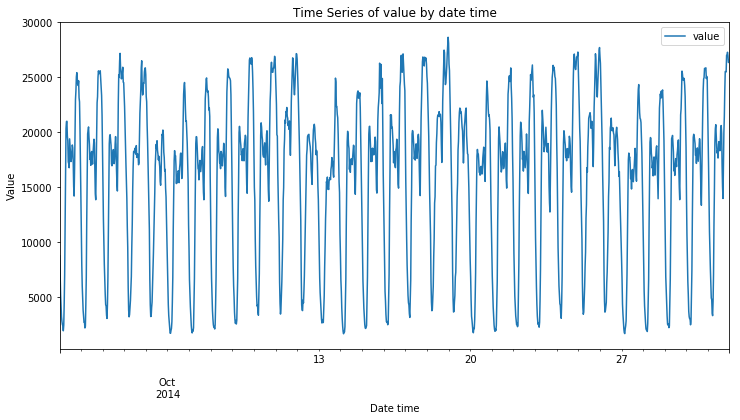

In [8]:
df2 = df[(df.Datetime > '2014-10-01') & (df.Datetime < '2014-11-01')]
print(df.shape)
df2.plot(x='Datetime', y='value', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

Text(0.5,1,'Time Series of value by date time')

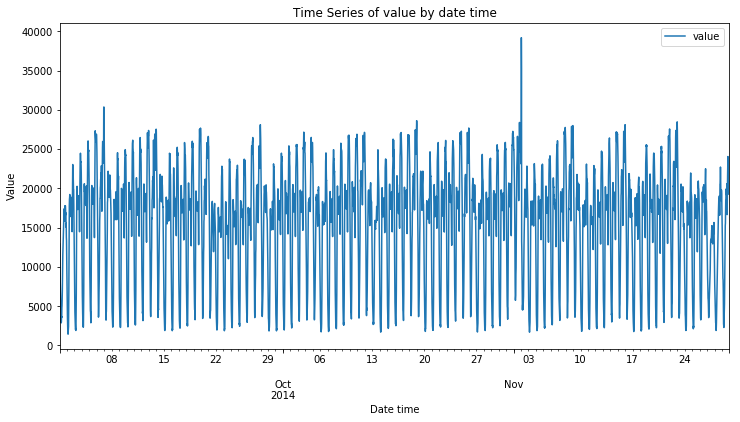

In [9]:
df2 = df[(df.Datetime > '2014-09-01') & (df.Datetime < '2014-11-30')]
df2.plot(x='Datetime', y='value', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

In [10]:
df.value.describe()

count     9503.000000
mean     15178.785962
std       6956.526818
min          8.000000
25%      10287.000000
50%      16837.000000
75%      19903.000000
max      39197.000000
Name: value, dtype: float64

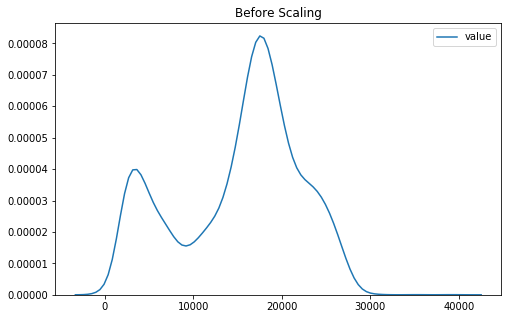

In [11]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(df['value'], ax=ax1)

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
df['scaled_value'] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df['value'])),columns=['value'])
print('Shape:' , df.shape[0])

df.head(5)

Shape: 9503


,timestamp,value,Datetime,dayofweek,month,hour,scaled_value
0,2014-07-18 00:30:00,16734,2014-07-18 00:30:00,4,7,0,0.426803
1,2014-07-18 01:00:00,14106,2014-07-18 01:00:00,4,7,1,0.359744
2,2014-07-18 01:30:00,11587,2014-07-18 01:30:00,4,7,1,0.295466
3,2014-07-18 02:00:00,8951,2014-07-18 02:00:00,4,7,2,0.228202
4,2014-07-18 02:30:00,7199,2014-07-18 02:30:00,4,7,2,0.183495


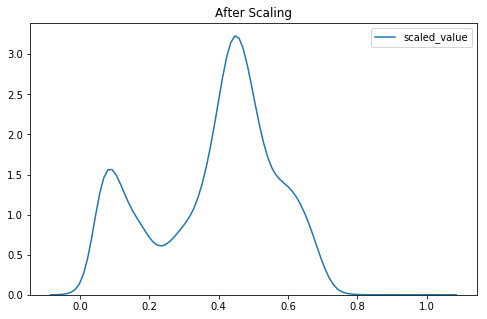

In [13]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 5))
ax1.set_title('After Scaling')
sns.kdeplot(df['scaled_value'], ax=ax1)

In [14]:
df.head(5)

,timestamp,value,Datetime,dayofweek,month,hour,scaled_value
0,2014-07-18 00:30:00,16734,2014-07-18 00:30:00,4,7,0,0.426803
1,2014-07-18 01:00:00,14106,2014-07-18 01:00:00,4,7,1,0.359744
2,2014-07-18 01:30:00,11587,2014-07-18 01:30:00,4,7,1,0.295466
3,2014-07-18 02:00:00,8951,2014-07-18 02:00:00,4,7,2,0.228202
4,2014-07-18 02:30:00,7199,2014-07-18 02:30:00,4,7,2,0.183495


In [15]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix: out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# choose a number of time steps
n_steps = 48
n_features =4
n_steps_out =1
# split into samples
rawsequence = np.array(df[['scaled_value', 'dayofweek', 'month', 'hour']].values)
#rawsequence = np.array(df['scaled_value'])
trainsequence = rawsequence[0:training_points]
testsequence = rawsequence[training_points:]

X_train, y_train = split_sequence(trainsequence, n_steps, n_steps_out)
X_test, y_test = split_sequence(testsequence, n_steps, n_steps_out)
# summarize the data
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

#print(rawsequence[0:12])
for i in range(2):
	print(X_train[i][0:4], y_train[i])

(4952, 48, 4) (4952, 1, 4)
(4455, 48, 4) (4455, 1, 4)
[[0.42680344 4.         7.         0.        ]
 [0.35974381 4.         7.         1.        ]
 [0.29546556 4.         7.         1.        ]
 [0.22820179 4.         7.         2.        ]] [[0.62816096 5.         7.         0.        ]]
[[0.35974381 4.         7.         1.        ]
 [0.29546556 4.         7.         1.        ]
 [0.22820179 4.         7.         2.        ]
 [0.18349537 4.         7.         2.        ]] [[0.57794279 5.         7.         1.        ]]


In [16]:
print(X_train.shape)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
print(X_train.shape)

(4952, 48, 4)
(4952, 48, 4)


In [17]:
print(y_train.shape)
# y_train = y_train.reshape(y_train.shape[0],y_train.shape[1],n_features)
y_train = y_train.reshape(y_train.shape[0], n_features)
print(y_train.shape)

(4952, 1, 4)
(4952, 4)


In [18]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [42]:
from keras.layers import regularizers, Flatten, MaxPooling1D, UpSampling1D, Lambda
from keras import backend as K
from keras.losses import mse


input_layer = Input (shape = (n_steps, n_features))
logfilename = "variationalautoencoder"


original_dim  = X_train.shape[1]

print(original_dim)

input_shape = (original_dim,)
intermediate_dim1 = 16
intermediate_dim2 = 8
batch_size = 32
latent_dim = 4
epochs = 20


# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim1, activation='relu')(inputs)
x = Dense(intermediate_dim2, activation='relu')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

# x = Dense(intermediate_dim2, activation='relu')(latent_inputs)
# x = Dense(intermediate_dim1, activation='relu')(x)
outputs = Dense(4, activation='linear')(latent_inputs)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')


# VAE loss = mse_loss or xent_loss + kl_loss
reconstruction_loss = mse(inputs, outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.005
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

48
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
encoder_input (InputLayer)       (None, 48)            0                                            
____________________________________________________________________________________________________
dense_36 (Dense)                 (None, 16)            784         encoder_input[0][0]              
____________________________________________________________________________________________________
dense_37 (Dense)                 (None, 8)             136         dense_36[0][0]                   
____________________________________________________________________________________________________
z_mean (Dense)                   (None, 4)             36          dense_37[0][0]                   
________________________________________________________________________________________

ValueError: Dimensions must be equal, but are 4 and 48 for 'sub_14' (op: 'Sub') with input shapes: [?,4], [?,48].

In [38]:


vae.compile(optimizer='adam', 
                    loss='mean_squared_error',
                    metrics=['accuracy'])
vae.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 48)                0         
_________________________________________________________________
encoder (Model)              [(None, 4), (None, 4), (N 992       
_________________________________________________________________
decoder (Model)              (None, 4)                 20        
Total params: 1,012
Trainable params: 1,012
Non-trainable params: 0
_________________________________________________________________


In [39]:
batch_size=48
epochs=200

vae.fit(x=X_train, y=y_train,
                       batch_size=batch_size, epochs=epochs,
                       verbose=1, 
                       callbacks=[TensorBoard(log_dir='/logs/{0}'.format(tensorlog))])

ValueError: Error when checking input: expected encoder_input to have 2 dimensions, but got array with shape (4952, 48, 4)

In [161]:
test1 = testsequence[:n_steps]
print(test1.shape)
test1.shape = (1, n_steps, n_features)
print(test1.shape)
test1_pred = model.predict(x=test1)
print(testsequence[n_steps-2:n_steps+2])
print(test1_pred)

test1 = testsequence[128:n_steps+128]
print(test1.shape)
test1.shape = (1, n_steps, n_features)
test1_pred = model.predict(x=test1)
print(testsequence[128+n_steps-2:128+n_steps+2])
print(test1_pred)

(48, 4)
(1, 48, 4)
[[ 0.12574957  4.         10.          3.        ]
 [ 0.12217714  4.         10.          4.        ]
 [ 0.09051009  4.         10.          4.        ]
 [ 0.08494731  4.         10.          5.        ]]
[[ 0.1421759  3.924029  10.072424   4.0959663]]
(48, 4)
[[ 0.55535992  6.         11.         19.        ]
 [ 0.53550741  6.         11.         20.        ]
 [ 0.50437623  6.         11.         20.        ]
 [ 0.46926433  6.         11.         21.        ]]
[[ 0.45864356  6.0157137  10.929048   20.120813  ]]


In [162]:
y_pred = model.predict(x=X_test)
y_pred

array([[ 0.1421758 ,  3.9240296 , 10.072422  ,  4.0959644 ],
       [ 0.16733612,  3.9140549 , 10.06442   ,  5.115516  ],
       [ 0.17250971,  3.923922  , 10.07027   ,  5.099459  ],
       ...,
       [ 0.43370518,  2.378057  ,  3.9934318 , 21.732033  ],
       [ 0.43055853,  2.3757133 ,  4.070884  , 22.73      ],
       [ 0.40649423,  2.3466878 ,  4.166533  , 22.658092  ]],
      dtype=float32)

In [163]:
y_test.shape = (y_test.shape[0], n_features)
y_test.shape

(4455, 4)

In [164]:

rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 1.100


In [165]:

#testing_dataset = sequence
print("testing_dataset: ", y_test.shape)
print("testing_pred: ", y_pred.shape)

print(y_test[128:130:])
print(y_pred[128:130])
errors = y_test - y_pred
print(errors.shape)
print(errors[128:130])

rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)

testing_dataset:  (4455, 4)
testing_pred:  (4455, 4)
[[ 0.50437623  6.         11.         20.        ]
 [ 0.46926433  6.         11.         21.        ]]
[[ 0.4586433  6.015713  10.929048  20.120811 ]
 [ 0.465212   6.0253854 10.963505  21.077732 ]]
(4455, 4)
[[ 0.04573294 -0.01571321  0.07095242 -0.12081146]
 [ 0.00405235 -0.02538538  0.03649521 -0.07773209]]
Test RMSE: 1.100


RangeIndex(start=5000, stop=9503, step=1)
(4455, 4)
       eval
0  0.051666
1  0.082389
2  0.053675
3  0.043553
4  0.067953
RangeIndex(start=0, stop=4455, step=1)
                Datetime  scaled_value  dayofweek  month  hour
5000 2014-10-30 04:30:00      0.063742          3     10     4
5001 2014-10-30 05:00:00      0.071780          3     10     5
5002 2014-10-30 05:30:00      0.134706          3     10     5
5003 2014-10-30 06:00:00      0.189313          3     10     6
5004 2014-10-30 06:30:00      0.312333          3     10     6
(4503, 5)
(4503, 6)
             Datetime  scaled_value  dayofweek  month  hour      eval
0 2014-10-30 04:30:00      0.063742          3     10     4  0.051666
1 2014-10-30 05:00:00      0.071780          3     10     5  0.082389
2 2014-10-30 05:30:00      0.134706          3     10     5  0.053675
3 2014-10-30 06:00:00      0.189313          3     10     6  0.043553
4 2014-10-30 06:30:00      0.312333          3     10     6  0.067953
             Dateti

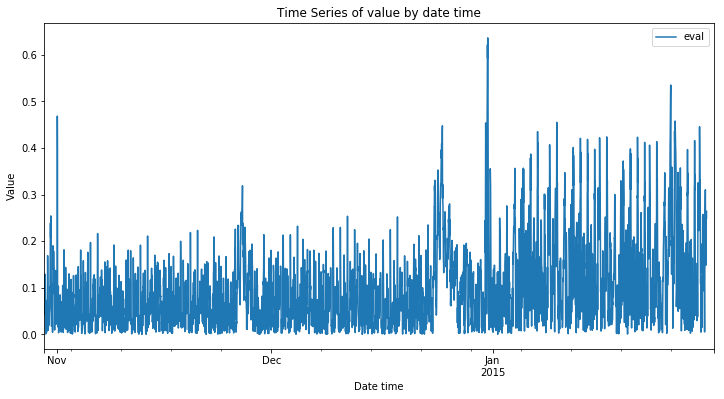

In [166]:
df2 = df.copy()
df2 = df2.loc[training_points:]
df2 = df2[['Datetime', 'scaled_value', "dayofweek", "month", "hour"]]
print(df2.index)

errorsDF = pd.DataFrame(errors, columns=['eval','edow','emonth','ehour'])
#errorsDF = pd.DataFrame(errors, columns=['a'])
print(errorsDF.shape)
errorsDF = errorsDF[['eval']]
errorsDF['eval'] = errorsDF['eval'].abs()
#errorsDF['predval']=scaler.inverse_transform(pd.DataFrame(errorsDF['predval']))
print(errorsDF.head(5))
print(errorsDF.index)

print(df2.head(5))
print(df2.shape)

df2.reset_index(drop=True, inplace=True)
errorsDF.reset_index(drop=True, inplace=True)

dfModified = pd.concat([df2, errorsDF], axis=1)
print(dfModified.shape)
print(dfModified.head(5))
dfModified.plot(x='Datetime', y='eval', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

df2 = dfModified[(dfModified.Datetime >= '2014-11-02') & (dfModified.Datetime < '2014-11-03')]
df2 = df2.reset_index(drop=True)
print(df2.head(5))

In [167]:
y_testDF = pd.DataFrame(y_test, columns=['val','origdow','origmonth','orighour'])
y_predDF = pd.DataFrame(y_pred, columns=['val','preddow','predmonth','predhour'])
y_testDF = y_testDF[['val']]
y_predDF = y_predDF[['val']]
#y_testDF['origval']=scaler.inverse_transform(pd.DataFrame(y_testDF['origval']))
#y_predDF['predval']=scaler.inverse_transform(pd.DataFrame(y_predDF['predval']))
print(y_testDF.head(5))
print(y_predDF.head(5))

        val
0  0.090510
1  0.084947
2  0.118834
3  0.180561
4  0.297864
        val
0  0.142176
1  0.167336
2  0.172510
3  0.224114
4  0.229911


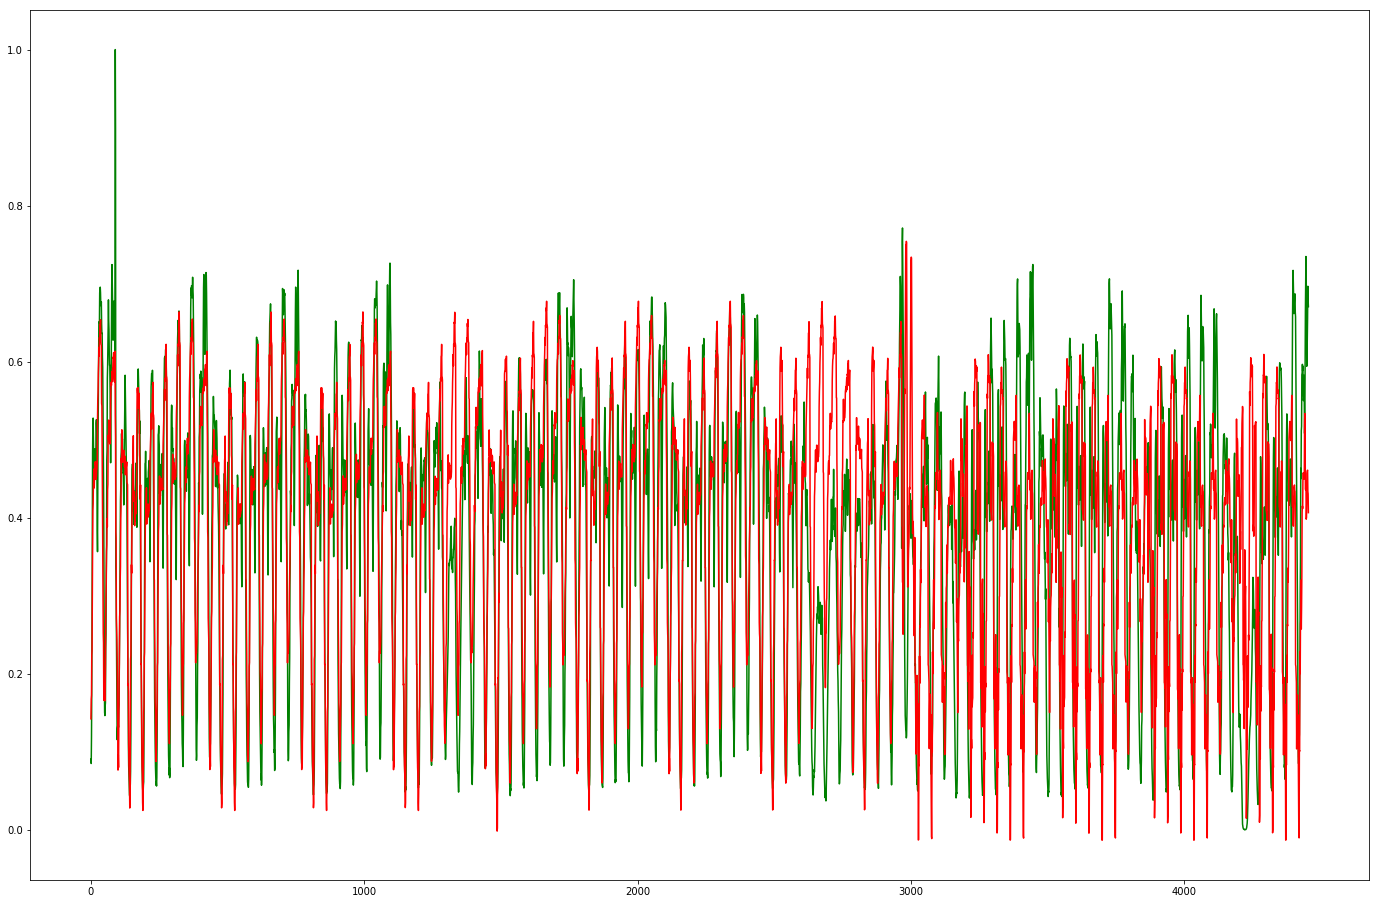

In [168]:
plt.figure(figsize=(24,16))
plt.plot(y_testDF, color='green')
plt.plot(y_predDF, color='red')

In [169]:
#based on cutoff after sorting errors
dist = np.linalg.norm(y_testDF - y_predDF, axis=-1)

scores =dist.copy()
print(scores.shape)
scores.sort()
cutoff = int(0.995 * len(scores))
print(cutoff)
print(scores[cutoff:])
threshold= scores[cutoff]


(4455,)
4432
[0.4341687  0.43522447 0.43576803 0.4361674  0.43838809 0.43885679
 0.44571722 0.44766014 0.45384331 0.45521761 0.45796221 0.46846718
 0.47571869 0.47591915 0.48888227 0.50999679 0.5241983  0.53360629
 0.53516812 0.59262603 0.62136966 0.63203606 0.63642065]


In [170]:
#label the records anomalies or not based on threshold
z = zip(dist >= threshold, dist)

y_label=np.zeros(df.shape[0])
error = np.zeros(df.shape[0])
i=training_points+n_steps
print(i)
for idx, (is_anomaly, dist) in enumerate(z):
    if is_anomaly:
        y_label[i] = 1
    error[i] = dist
    i = i + 1
print(len(y_label))
print(len(error))

5048
9503
9503


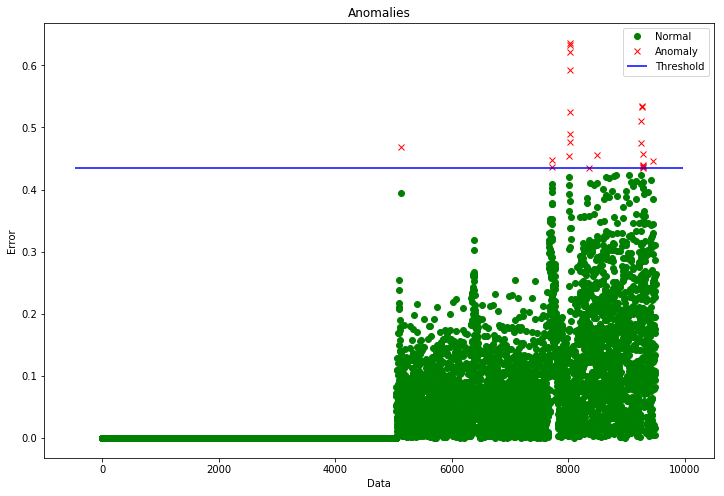

In [171]:
viz = Visualization()
viz.draw_anomaly(y_label, error, threshold)

In [172]:
print(df.shape)
print(len(y_label))
adf = pd.DataFrame({'Datetime': df['Datetime'], 'observation': df['scaled_value'],
                    'error': error, 'anomaly': y_label})
adf.head(5)


(9503, 7)
9503


,Datetime,observation,error,anomaly
0,2014-07-18 00:30:00,0.426803,0.0,0.0
1,2014-07-18 01:00:00,0.359744,0.0,0.0
2,2014-07-18 01:30:00,0.295466,0.0,0.0
3,2014-07-18 02:00:00,0.228202,0.0,0.0
4,2014-07-18 02:30:00,0.183495,0.0,0.0


Text(0.5,1,'Time Series of value by date time')

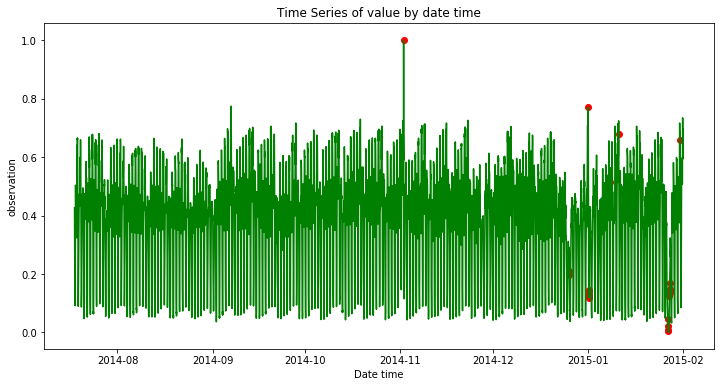

In [173]:


figure, axes = plt.subplots(figsize=(12, 6))
axes.plot(adf['Datetime'], adf['observation'], color='g')
anomaliesDF = adf.query('anomaly == 1')
axes.scatter(anomaliesDF['Datetime'].values, anomaliesDF['observation'], color='r')
plt.xlabel('Date time')
plt.ylabel('observation')
plt.title('Time Series of value by date time')